In [84]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

## 1. Creating Multi-Class Data ##

In [100]:
# Set the hyperparameters for the data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create data
X, y = make_blobs(n_samples=5000,
                   n_features=NUM_FEATURES,
                   centers=NUM_CLASSES,
                   cluster_std=1.5,
                   random_state=RANDOM_SEED)

# 2. Turn the data into tensors
X = torch.from_numpy(X).type(torch.float)
# torch.LongTensor creates a 64-bit integer (dtype) on the CPU
y = torch.from_numpy(y).type(torch.LongTensor)

# 3. Training-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# 4. Visualize the data
def visualize_data():
    plt.figure(figsize=(7,5))
    plt.scatter(X[:,0], X[:, 1], c=y, s=2, cmap=plt.cm.RdYlBu)

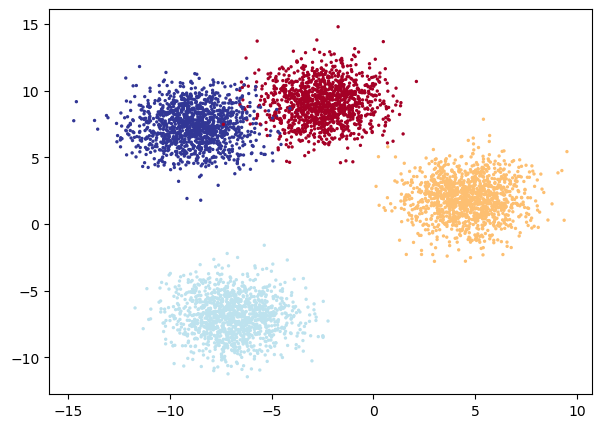

In [101]:
visualize_data()

## Building a Model ##

In [102]:
# Device Agnostic Programming
device = "mps" if torch.backends.mps.is_available() else "cpu"

# 1. Construct model class
class MulticlassClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()

        # Create a neural network with two hidden layers
        # Input is two-dimensional, output one dimensional
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=)
        self.relu = nn.ReLU()
        
    # Define the calculation in the forward pass
    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
        

In [103]:
model = MulticlassClassificationModel().to(device)

In [104]:
# Defining the loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

# Calculate accuracy based on a prediction and ground truth
def accuracy_function(y_true, y_pred):
    # torch.eq calculates where the two arguments are equal,
    # this gets summed up and turned into a python number
    correct = torch.eq(y_true, y_pred).sum().item()
    # Return the percentage of correctly classified elements
    return (correct / len(y_pred)) * 100

In [105]:
!pip -q install torchmetrics
# Calculate accuracy based on a prediction and ground truth
from torchmetrics import Accuracy
accuracy_function = Accuracy(task="multiclass", num_classes=3).to(device)

In [106]:
# Build training and evaluation loop

torch.manual_seed(42)
epochs = 1001

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    
    """
    Training
    """
    model.train()
    
    # 1. Forward Pass
    y_logits = model(X_train)
    # Take the class with highest probability as prediction
    y_pred = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
  
    # 2. Calulcate loss and accuracy
    #    Here we can use the raw logits because we used nn.BCEWithLogitsLoss before
    loss = loss_function(y_logits, y_train)
    acc = accuracy_function(y_pred, y_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()


    """
    Testing
    """
    model.eval()
    with torch.inference_mode():
        
        # 1. Forward pass
        test_logits = model(X_test)
        test_pred = torch.argmax(torch.softmax(test_logits, dim=1), dim=1)

        # 2. Calulcate loss and accuracy
        test_loss = loss_function(test_logits, y_test)
        test_acc = accuracy_function(test_pred, y_test)

    # Print current state every 10 epochs
    if epoch % 200 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}")


RuntimeError: Detected more unique values in `target` than expected. Expected only 3 but found 4 in `target`.

In [ ]:
from helper_functions import plot_predictions, plot_decision_boundary

# Visualize the decision boundaries for the training and test set
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)